# TP1 "Detección de ondas gravitacionales"

## Integrantes
- Ian Díaz
- Martín Rodriguez Turco
- Agustin Galdeman

### Links utiles de referencia

- https://web.archive.org/web/20180321162912/https://losc.ligo.org/events/GW150914/
- https://web.archive.org/web/20180615185011/https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html
- https://www.gw-openscience.org/eventapi/html/O3_Discovery_Papers/GW190814/v1/
- https://pypi.org/project/pyFFTW/

## Loading Dataset



https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/



In [ ]:
import numpy as np

from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import seaborn as sn
import scipy as sp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import importlib.util
spec = importlib.util.spec_from_file_location("readligo", "/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py")
readligo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(readligo)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFZ-OTWSLmhl6Ahy3Wyf4L672No8rgfJE2Hl2vJyDbhzl_8cI9pLyw
Mounted at /content/drive/


In [ ]:
use_32_seconds = True

if use_32_seconds is True:
  strain_H1, time_H1, chan_dict_H1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5", 'H1');
  strain_L1, time_L1, chan_dict_L1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5", 'L1');
else:
  strain_H1, time_H1, chan_dict_H1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5", 'H1');
  strain_L1, time_L1, chan_dict_L1 = readligo.loaddata("/content/drive/Shared drives/PASA/TP1 Black Hole/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5", 'L1');

/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
/content/drive/Shared drives/PASA/TP1 Black Hole/readligo/readligo.py:143: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


Separamos las señales de strain de Hamford y Livingstones en 3 partes:

SILENCIO ---- EVENTO ---- SILENCIO

Denominamos SILENCIO a aquella parte del strain donde **no** se encuentra el evento. 
Además, para conseguir poder tener una representación más pura del ruido que afecta a la medición se dejaron de lado un cierto número de muestras como guarda

In [ ]:
# sampling rate:
fs = 4096
# Duración del evento en samples
event_duration_seconds = 0.2
event_duration_samples = int(np.ceil(fs * event_duration_seconds)) # Aproximadamente 820 muestras
print(event_duration_samples)
# Con el fin de evitar cualquier potencial contaminación de los segmentos silenciosos
# del strain se decidio dejar una espacio de guarda entre el comienzo del evento 
# y otra guarda adicional al final de este. 
guarda = 100


index_H1 = np.where(time_H1 >= 1126259462.4)[0][0]  #Comienzo del evento en Hamford

silencio_1_H1 = strain_H1[0 : (index_H1 - guarda)] # Primer periodo silencioso
evento_H1 = strain_H1[ index_H1: (event_duration_samples + index_H1 )]
tiempo_evento = time_H1[index_H1: (event_duration_samples + index_H1 )]
silencio_2_H1 = strain_H1[ event_duration_samples + index_H1 + guarda : event_duration_samples + index_H1 + guarda + len(silencio_1_H1)]

# Garantizamos que las señales tengan media nula
silencio_1_H1 = silencio_1_H1 - np.mean(silencio_1_H1)
silencio_2_H1 = silencio_2_H1 - np.mean(silencio_2_H1)

# Repetimos el mismo proceso para Livingstone 

# Livingstone
index_L1 = np.where(time_L1 >= 1126259462.4)[0][0]
silencio_1_L1 = strain_L1[0 : (index_L1 - guarda)]
evento_L1 = strain_L1[ index_L1 : (event_duration_samples + index_L1)]
silencio_2_L1 = strain_L1[ event_duration_samples + index_L1 + guarda : event_duration_samples + index_L1 + guarda + len(silencio_1_L1)]

silencio_1_L1 = silencio_1_L1 - np.mean(silencio_1_L1)
silencio_2_L1 = silencio_2_L1 - np.mean(silencio_2_L1)

# Si por alguna razón usamos las señales de 32 segundos de duración
if use_32_seconds is False:
  scale_factor = 10 
  silencio_1_H1 = silencio_1_H1[:len(silencio_1_H1)//scale_factor]
  silencio_2_H1 = silencio_2_H1[:len(silencio_2_H1)//scale_factor]
  silencio_1_L1 = silencio_1_L1[:len(silencio_1_L1)//scale_factor]
  silencio_2_L1 = silencio_2_L1[:len(silencio_2_L1)//scale_factor]


# Ahora realizamos el mismo pre-procesamiento para la zona temporal donde 
# esperamos encontrar el chirp
evento_H1  = evento_H1 - np.mean(evento_H1)
evento_L1  = evento_L1 - np.mean(evento_L1)


silences = [silencio_1_H1, silencio_2_H1, silencio_1_L1, silencio_2_L1]
events = [evento_H1, evento_L1]
titles = ["Periodograma 1er silencio Hanford", "Periodograma 2do silencio Hanford", "Periodograma 1er silencio Livingston", "Periodograma 2do silencio Livingston"]

del silencio_1_H1
del silencio_2_H1
del silencio_1_L1
del silencio_2_L1
del evento_H1
del evento_L1
del index_H1
del index_L1
del guarda

820


## Estimación del espectro de ruido mediante FFT 

Se procede a calcular la autocorrelacion de cada silencio respectivamente. 
Dado que el estimador de la correlación arroja resultados pocos confiables conforme aumenta *L*(lag) se aplico la regla de Box & Jenkins para quedarnos con los datos más confiables.
Luego, la función de autocorrelación es devuelta y sus bordes suavizados con una ventana de hanning. Esto nos permitio reducir el leakage espectral que se producia al realizar la fft.

In [ ]:
def do_autocorr(X, L=None):
  auto_cor = signal.correlate(X, X, method= "fft") / len(X)
  #Aplicando la regla de Box & Jenkins
  L = int(len(X)/4) 
  if len(auto_cor)%2 == 0:
    c = int((len(auto_cor)-1)/2)
    print(c,L)
    auto_cor = auto_cor[c-L:c+L]
  else:
    c = int((len(auto_cor))/2)
    auto_cor = auto_cor[c-L:c+L+1]
  
  auto_cor = auto_cor*signal.hann(len(auto_cor))
  return auto_cor

autocorrelations = []
event_autocorrelations = []

for silence in silences:
  silence = silence*signal.hann(len(silence))
  autocorrelations.append(do_autocorr(silence))

for event in events:
  event = event*signal.hann(len(event))
  event_autocorrelations.append(do_autocorr(event))

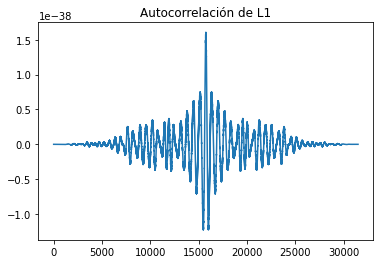

In [ ]:
plt.title("Autocorrelación de L1")
plt.plot(autocorrelations[2]);

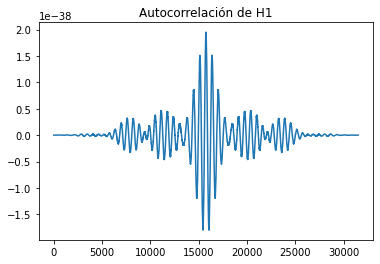

In [ ]:
plt.title("Autocorrelación de H1")
plt.plot(autocorrelations[0]);

Se calcula la DFT de la autocorrelacion de cada una la cual nos da la PSD, luego para llegar al modulo del espectro de la señal, se le aplica la raiz cuadrada al valor absoluto de la PSD

In [ ]:
# Calculamos la transformada de la autocorrelación para obtener la PSD (power spectral density)
def compute_periodogram(auto_corr, fs=4096):
  psd = np.fft.fft(auto_corr)
  freqs = np.fft.fftfreq(len(psd), d=1/fs)
  return freqs, psd 

In [ ]:
def plot_fft(freqs, spectrum, title=None, label=None, axis_fft=None):
  plt.figure(figsize=(7,7))
  if axis_fft is not None:
    plt.axis(axis_fft) #[10,2e3,5e-21,1e-14]

  plt.grid(axis='both', which='both')
  if title is not None:
    plt.title(title)

  if label is not None:
    plt.loglog(freqs, spectrum, label=label)
  else:
    plt.loglog(freqs, spectrum, label=label)

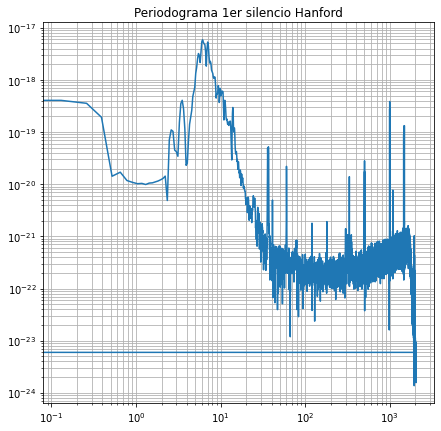

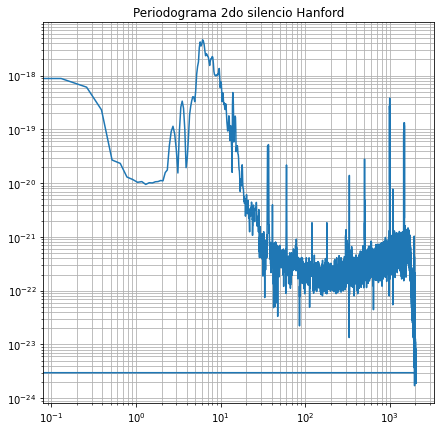

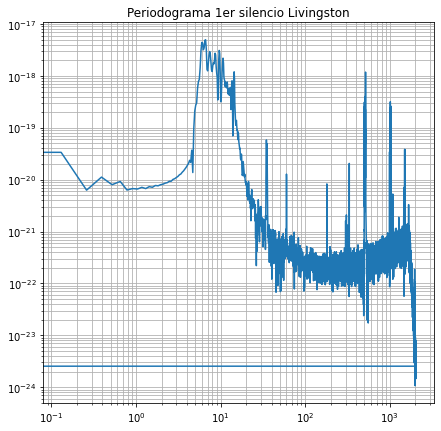

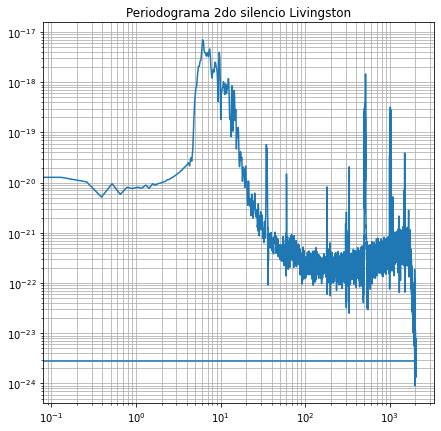

In [ ]:
psds_originales = []
psd_freqs_originales = []

for autocorrelation in autocorrelations:
  freqs_PSD, PSD = compute_periodogram(autocorrelation)
  psds_originales.append(PSD)
  psd_freqs_originales.append(freqs_PSD)

for i in range(len(psd_freqs_originales)):
  plot_fft(psd_freqs_originales[i], np.sqrt(np.abs(psds_originales[i])), titles[i])

## Estimación del espectro mediante el método de Blackman-Tukey


El metodo de Blackman Tukey ofrece un suavizado en el espectro ofreciendo una ventaja computacional por su metodo de calculo.

Material de referencia
Pagina 222 Manolakis

- N: tamaño del vector de la data
- M: coeficiente que regula el tamaño de la ventana rectangular en el espectro. NO REPRESENTA EL ANCHO EN TAPS COMO TAL!

Los pasos seguidos a continuacion son:

- Calcular la autocorrelacion desde -(L-1) hasta L-1
- Ventanear la autocorrelacion con la ventana:

$$\omega_a(l)=\frac{sin\left(l\frac{\Delta \omega}{2}\right)}{\pi l}$$

Como, en nuestro caso, el tiempo de computo no es un limitante se decidio tomar L = N. Por lo tanto el vector de estimación de autocorrelación tendra $2N-2$ datos.

- Calcular la DFT utilizando la FFT

Por lo tanto, obtenemos:

$$\hat{R_x}(e^{j\omega})|_{\omega=\frac{2k}{N_{FFT}}}$$

La funcion **get_ventana_bktukey(M,N)** devuelve una ventana como la que se menciono anteriormente de 2N-2 valores

In [ ]:
def get_ventana_bktukey(M, N):
  delta_omega = (2*np.pi/N)*(2*M+1)
  time = np.arange(-N+1,N)
  window = np.sinc(time*delta_omega/(2*np.pi)) * (delta_omega/(2*np.pi))
  window = window/max(window)                                    
  return window

In [ ]:
def do_btuckey(X, M=15):
  #Para evitar spectral leackage aplicamos una ventana de Hanning
  X = X*signal.windows.hann(len(X))
  auto_corr_bt = do_autocorr(X)
  #Ahora aplicamos la ventana que funcionara como MA en el espectro
  window = get_ventana_bktukey(M, len(auto_corr_bt)//2+1) 
  auto_corr_bt = auto_corr_bt*window

  freqs, psd_spectre = compute_periodogram(auto_corr_bt)

  return freqs, psd_spectre

Aca se obtiene la ventana deseada para el 1er silencio (los primeros 15 segundos de la señal de Hanford), se multiplica la autocorrelacion por la ventana obtenida y se le aplica la fft y la raiz cuadrada para obtener el espectro de la señal.

Cargo en la variable **btuckey_spectres** los espectros de cada caso con la estimacion de Blackman-Tuckey , y en la variable **btuckey_freqs** las respectivas frecuencias

Se decidio utilizar M=5 como parametro ya que luego de sucesivas iteraciones se noto que ofrecia la mejor relación de suavidad y de ajuste a la forma general del espectro.

In [ ]:
btuckey_psds = []
btuckey_freqs = []
for silence in silences:
  freqs, psd = do_btuckey(silence, M=5)
  btuckey_psds.append(psd)
  btuckey_freqs.append(freqs)

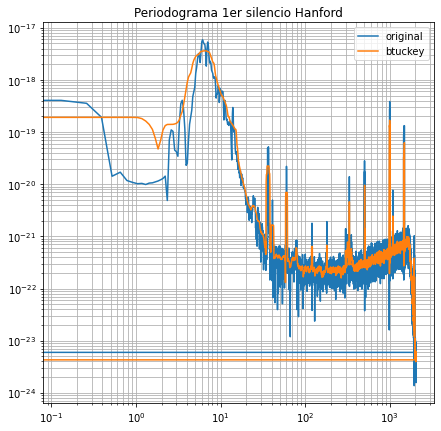

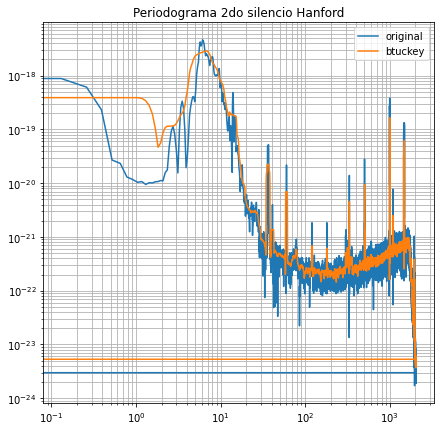

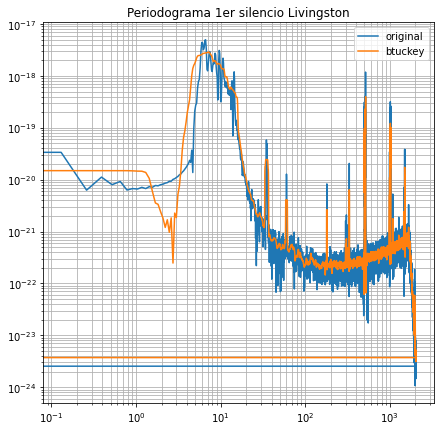

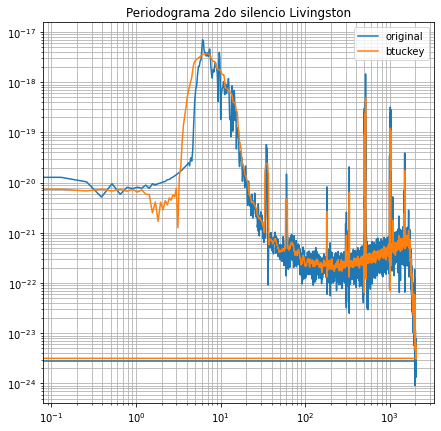

In [ ]:
for counter, title in enumerate(titles):
  plt.figure(figsize=(7,7))
  plt.title(titles[counter])
  plt.grid(axis='both', which='both')
  plt.loglog(psd_freqs_originales[counter], np.sqrt(np.abs(psds_originales[counter])), label="original")
  plt.loglog(btuckey_freqs[counter],np.sqrt(np.abs(btuckey_psds[counter])), label="btuckey")
  plt.legend()
  plt.show()

Como se puede observar, hay una gran mejora respecto a la suavidad del espectro y se obtiene una mejor representacion del espectro real de la señal.

## Estimación del espectro mediante el método de Welch-Bartlett

Este metodo apunta a disminuir la varianza de la estimacion del espectro mediante la promediacion de muchas PSDs.

La siguiente función parte los datos en varios segmentos de igual longitud, les calcula la FFT por separado de cada segmento, y las promedia.

In [ ]:
from scipy import signal

def do_welch_barlett(data, k):
  '''
  Aplica el metodo de Welch-Bartlett sobre un serie de tiempo
  '''
  L = int(len(data)/k)
  splits = []

  for i in range(k):
    new_segment = []
    for u in range(L):
      new_segment.append(data[u+(i)*L])
    splits.append(new_segment)

  ffts = []
  ffts_freqs = []
  for segment in splits:
    segment = segment*signal.hann(len(segment))
    spectrum = np.abs(np.fft.fft(segment))**2 #PSD
    ffts.append(spectrum)
    freqs = np.fft.fftfreq(len(spectrum),d=1/fs)
    ffts_freqs.append(freqs)

  avg_ffts = np.sum(ffts, axis=0)/(L*k)
  return ffts_freqs[0], avg_ffts

Cargo en la variable **wbartlett_spectres** los espectros de cada caso con la estimacion de Welch-Bartlett , y en la variable **wbartlett_freqs** las respectivas frecuencias.

Se decidio utilizar k=15 divisiones de los segmentos de silencio dado que ofrecia un buen balance entre suavidad y resolución espectral.

In [ ]:
wbartlett_spectres = []
wbartlett_freqs = []
for index, silence in enumerate(silences):
  n = 15
  freq_wb, psd_wb = do_welch_barlett(silence, n)
  wbartlett_spectres.append(psd_wb)
  wbartlett_freqs.append(freq_wb)

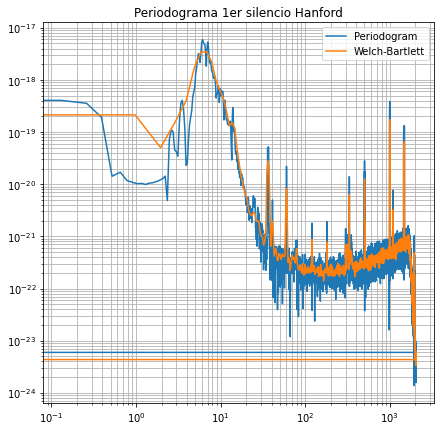

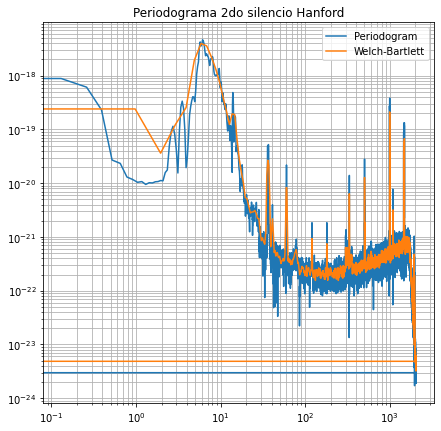

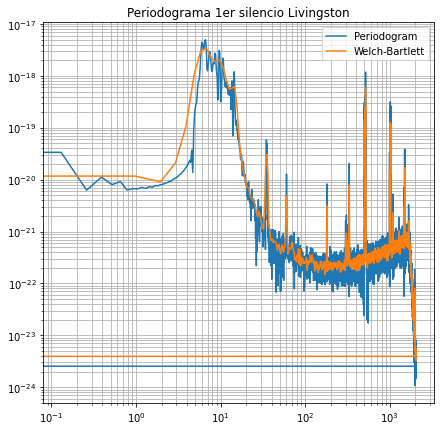

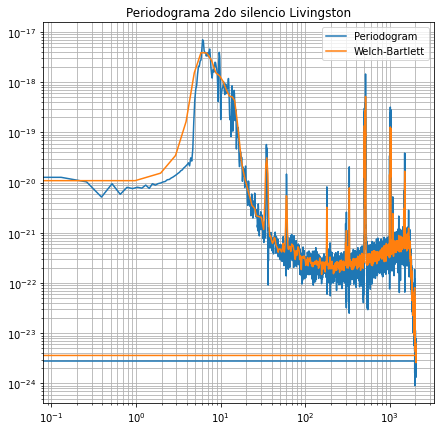

In [ ]:
for counter, title in enumerate(titles):
  plt.figure(figsize=(7,7))
  plt.title(titles[counter])
  plt.grid(axis='both', which='both')
  plt.loglog(psd_freqs_originales[counter], np.sqrt(np.abs(psds_originales[counter])), label="Periodogram")
  plt.loglog(wbartlett_freqs[counter],np.sqrt(np.abs(wbartlett_spectres[counter])), label="Welch-Bartlett")
  plt.legend()
  plt.show()

## Estimación del espectro mediante el método de Multitaper


El método de multitaper consiste en ventanerar una secuencia de datos de entrada temporales con diferentes ventanas o **tapers**, que en nuestro caso van a ser las secuencias DPSS (Discrete prolate spheroidal sequences por sus siglas en inglés). A cada una de estas señales de entradas ventaneadas, se le calcula la FFT y finalmente, se promedian todas las FFTs obtenidas para obtener el resultado final.

Las funciones DPSS son de la forma:

$$\omega_k (n) = \sqrt{\frac{2}{N+1}}sin\left( \frac{\pi(k+1)(n+1)}{N+1} \right)$$

En nuestro caso, utilizaremos el método **scipy.signal.windows.dpss()** para obtener estas funciones

A continuacion se puede observar la funcion que realiza el multitaper de una secuencia de datos.

In [ ]:
def multitaper(input_sig, NW=100, K=10):
  tapers = signal.windows.dpss(len(input_sig), NW, K )#, sym=False, norm="approximate")

  taped_signals = []
  
  #Aplicamos las ventanas sepianas a la señal
  psds_mt = [] 
  freqs_mtap = []
  for tape in tapers:
    taped_signal = tape*input_sig*signal.windows.hann(len(input_sig))
    psd_mt = np.abs(np.fft.fft(taped_signal))**2
    freq_mt = np.fft.fftfreq(len(psd_mt), d=1/fs)
    psds_mt.append(psd_mt)
    freqs_mtap.append(freq_mt)

  #Calculamos el promedio de los peridogramas
  avg_periodogram = np.mean(psds_mt, axis=0)

  return freqs_mtap[0], avg_periodogram

In [ ]:
NW = 100
K = 10
multitaper_spectres = []
multitaper_freqs = []
for index, silence in enumerate(silences):
  f, spectrum = multitaper(silence, NW, K)
  multitaper_spectres.append(spectrum)
  multitaper_freqs.append(f)

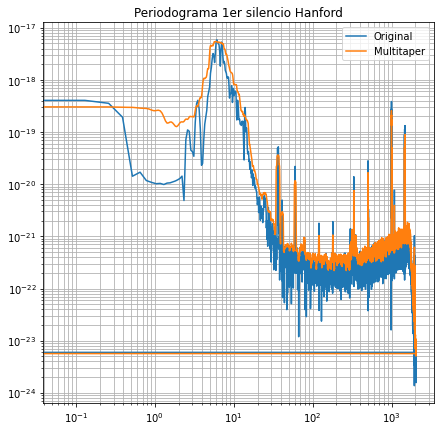

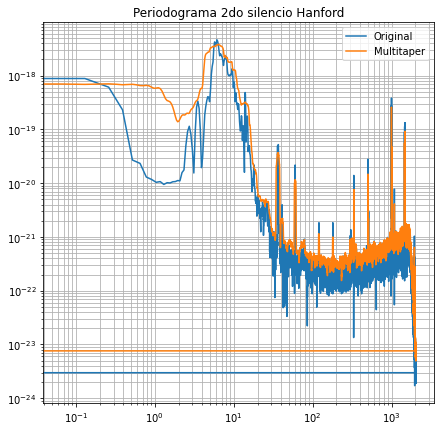

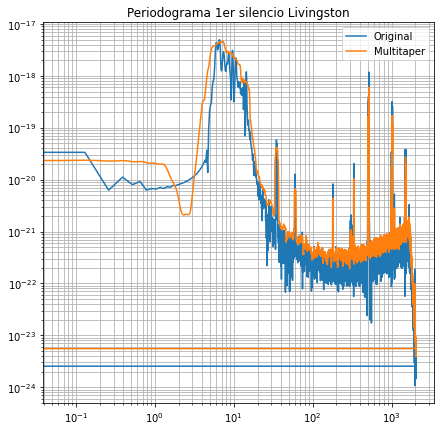

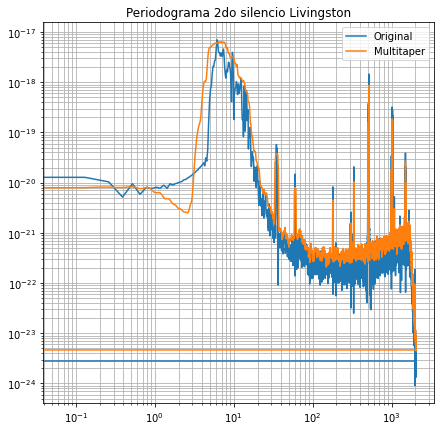

In [ ]:
for counter, title in enumerate(titles):
  plt.figure(figsize=(7,7))
  plt.title(titles[counter])
  plt.grid(axis='both', which='both')
  plt.loglog(psd_freqs_originales[counter], np.sqrt(np.abs(psds_originales[counter])), label="Original")
  plt.loglog(multitaper_freqs[counter],np.sqrt(np.abs(multitaper_spectres[counter])), label="Multitaper")
  plt.legend()
  plt.show()

## Estimar la función de distribución de probabilidad y el espectro de potencia alprincipio y al final de la señal de 32 s, a fin de validar la estacionaridad del ruido deH1 y L1.

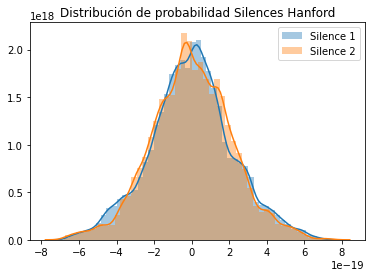

In [ ]:
#Distribución de probabilidad
plt.title("Distribución de probabilidad Silences Hanford")
sn.distplot(silences[0], label="Silence 1")
sn.distplot(silences[1], label="Silence 2")
plt.legend();

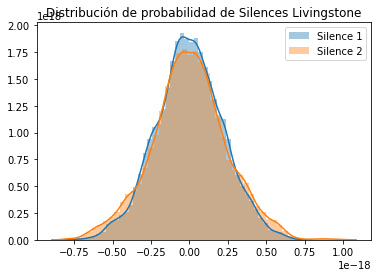

In [ ]:
plt.title("Distribución de probabilidad de Silences Livingstone")
sn.distplot(silences[2], label="Silence 1")
sn.distplot(silences[3], label="Silence 2")
plt.legend();

Podemos observar que la distribución de probabilidad de las señales de silencio se conservan antes y despues del evento.

## Whitening
Vamos a realizar el proceso de whitening utilizando el metodo de estimación espectral de Blackman-Tuckey con un factor $M=5$.


Para realizarlo se utilizaron las estimaciones espectrales de los primeros tramos de silencio de cada strain. Cada uno compuesto por aproximadamente 60.000 muestras que representan unos 15 segundos de silencio previos a la ocurrencia del evento.


Como se desea blanquear todo el strain se aplica una ventana de hanning sobre el segmento de **silencio** seguida de un zero-padding sobre el mismo para conseguir la mejor resolución espectral posible y ajustarla a la cantidad de puntos que presenta la estimación del periodograma de todo el strain.

Finalmente se implemento un algoritmo de división que en el cual se busca dividir los valores de la DFT del strain con los valores obtenidos del silecnio. 

Por ultimo, para recuperar la señal en el dominio del tiempo se empleo al ifft.

In [ ]:
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')

def find_nearest(x, data):
  return np.argmin(np.abs(data-x))

#Vamos a usar Hamford Silencio 1 con Strain 1
def whiten_btuckey(strain, silence, MM=5, fs=4096):
  strain_spectrum = np.fft.fft(strain)
  strain_freqs = np.fft.fftfreq(len(strain_spectrum), d=1/fs)
  
  silence = silence*signal.hann(len(silence)) # Evitamos spectral leakage.
  silence_padded = np.pad(silence, len(strain))
  silence_freqs, silence_spectrum = do_btuckey(silence_padded, M=MM)

  #Ahora debemos dividir el espectro del strain por el espectro del silencio
  resultado = []
  for strain_freq, asd in zip(strain_freqs, strain_spectrum):
    closest_index = find_nearest(strain_freq, silence_freqs)
    divide = asd/np.sqrt(np.abs(silence_spectrum[closest_index]))
    resultado.append(divide)

  whitened_strain = np.fft.ifft(resultado)
  return whitened_strain, resultado

## Realizamos el blanque del **strain H1** usando el espectro estimado para la primera mitad del **strain H1**

### Primero blanqueamos la señal

In [ ]:
w_strain, asd = whiten_btuckey(strain_H1, silences[0])

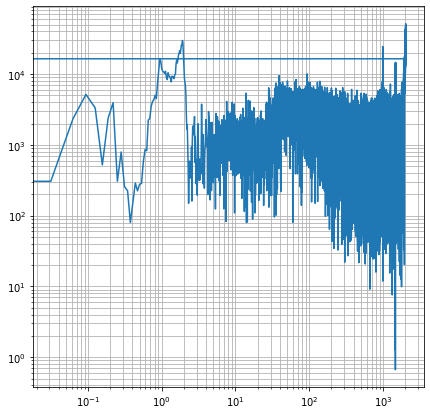

In [ ]:
plot_fft(np.fft.fftfreq(len(asd),d=1/fs), np.abs(asd))

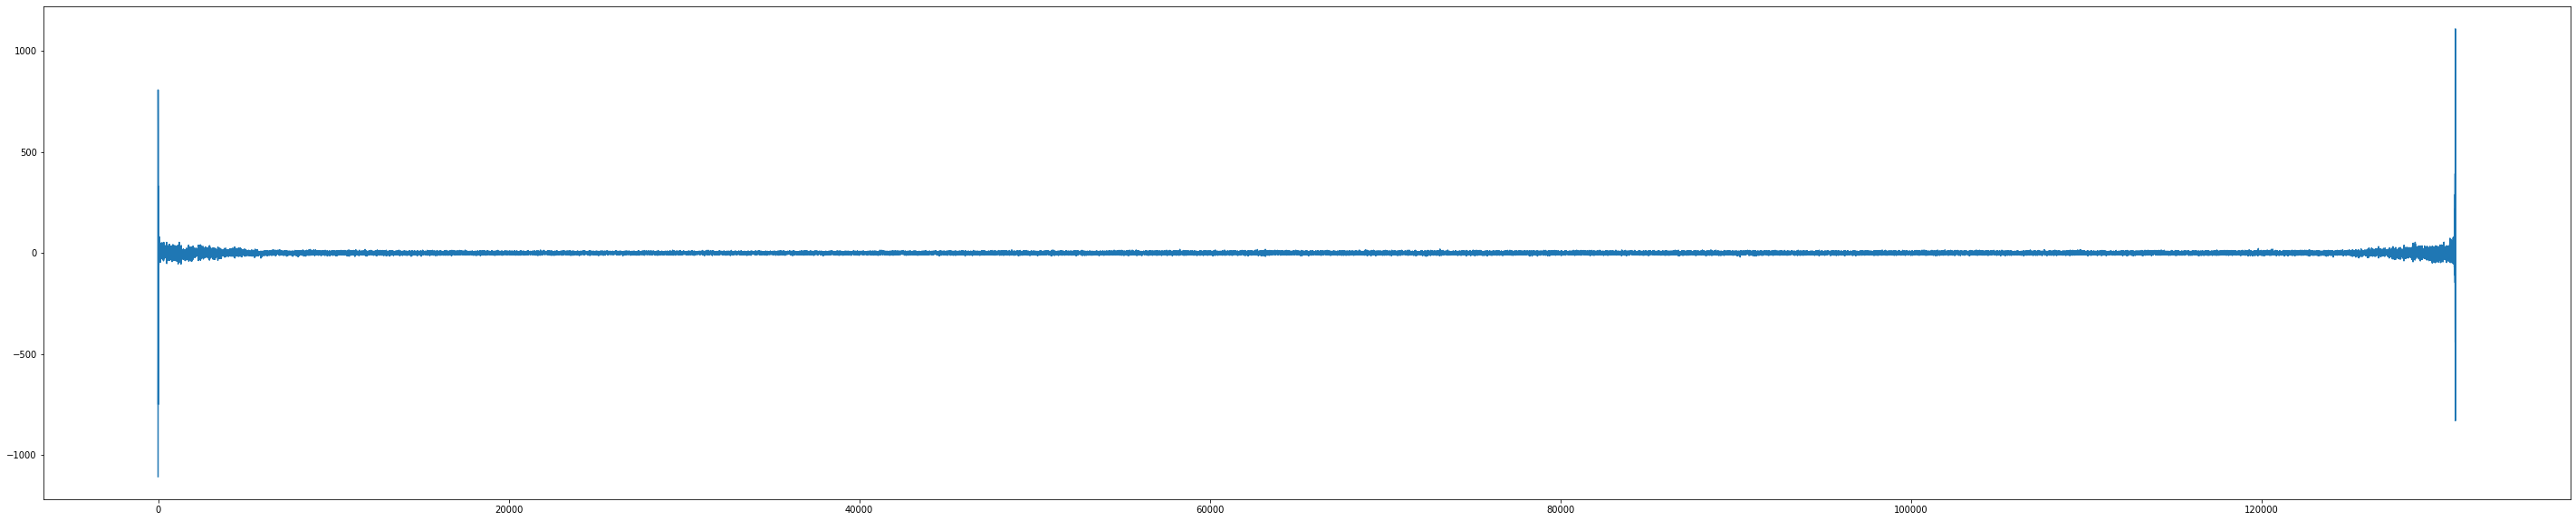

In [ ]:
plt.figure(figsize=(50,10));
plt.plot(np.real(w_strain))

Parece que no hay nada...
Sin embargo, se sabe gracias a los resultados teoricos que el chirp se encuentra en la banda de entre 30Hz y 300Hz. Por lo que aplicaremos un filtro pasabanda butterworth de orden 4.

In [ ]:
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, np.real(w_strain))

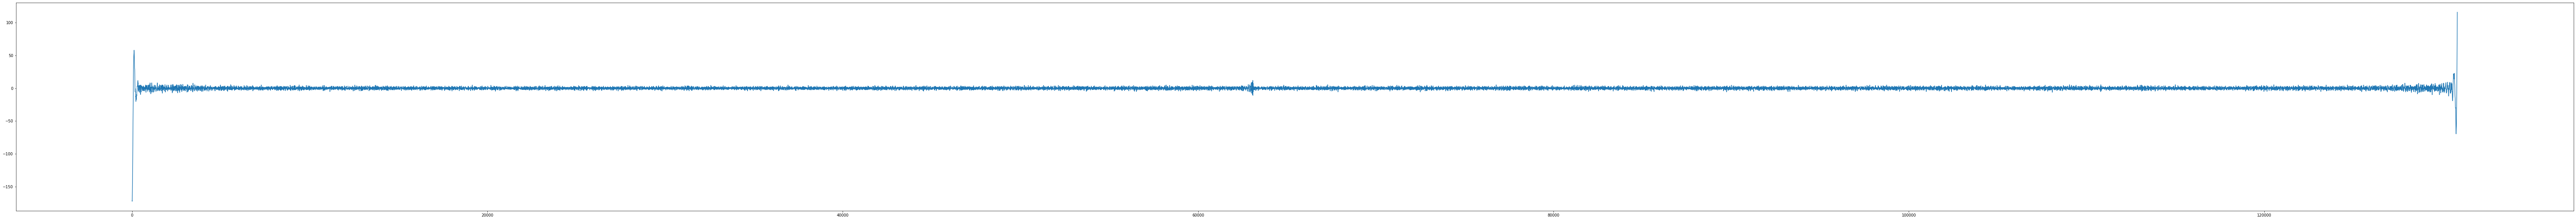

In [ ]:
plt.figure(figsize=(120,10));
index_H1 = np.where(time_H1 >= 1126259462.4)[0][0]
plt.plot(np.real(strain_H1_whitenbp[100:-100]));

### ¡¡Hay algo en el centro!!
Hagamos zoom!

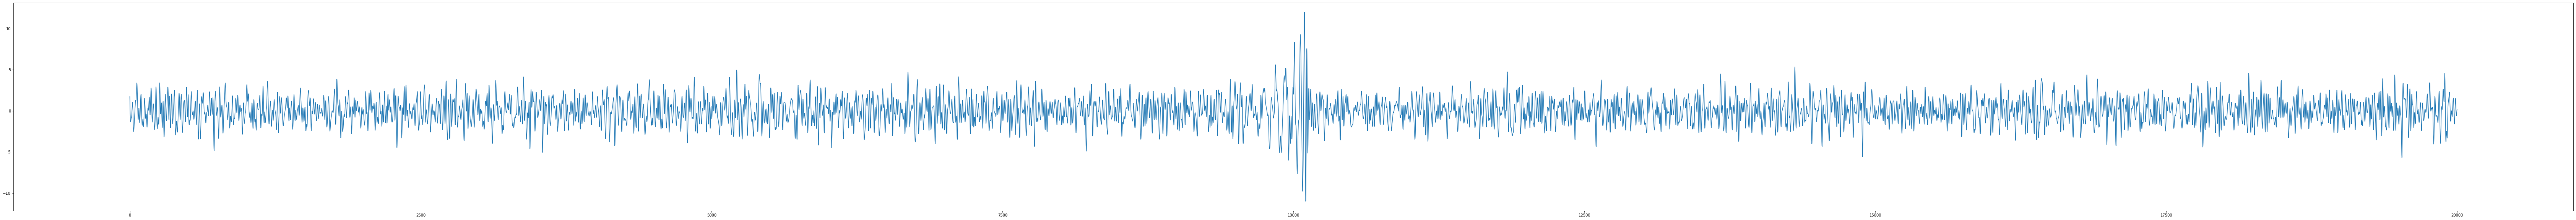

In [ ]:
plt.figure(figsize=(120,10));
index_H1 = np.where(time_H1 >= 1126259462.4)[0][0]
plt.plot(np.real(strain_H1_whitenbp[index_H1-10000: index_H1 + 10000]));

### Más zoom!!!

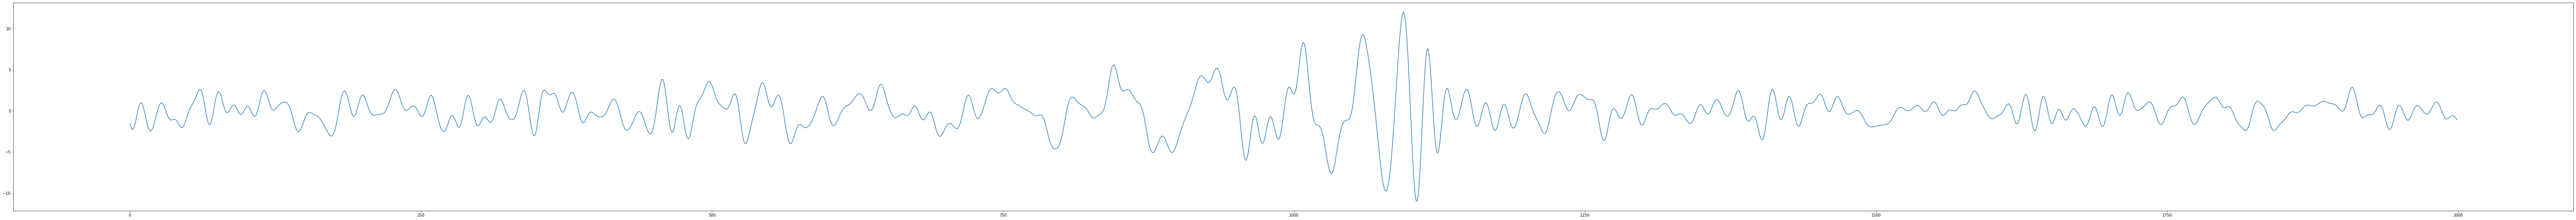

In [ ]:
plt.figure(figsize=(120,10));
index_H1 = np.where(time_H1 >= 1126259462.4)[0][0]
plt.plot(np.real(strain_H1_whitenbp[index_H1-1000: index_H1 + 1000]));

¡¡Eureka!! Hemos encontrado el **chirp**

Livingstone

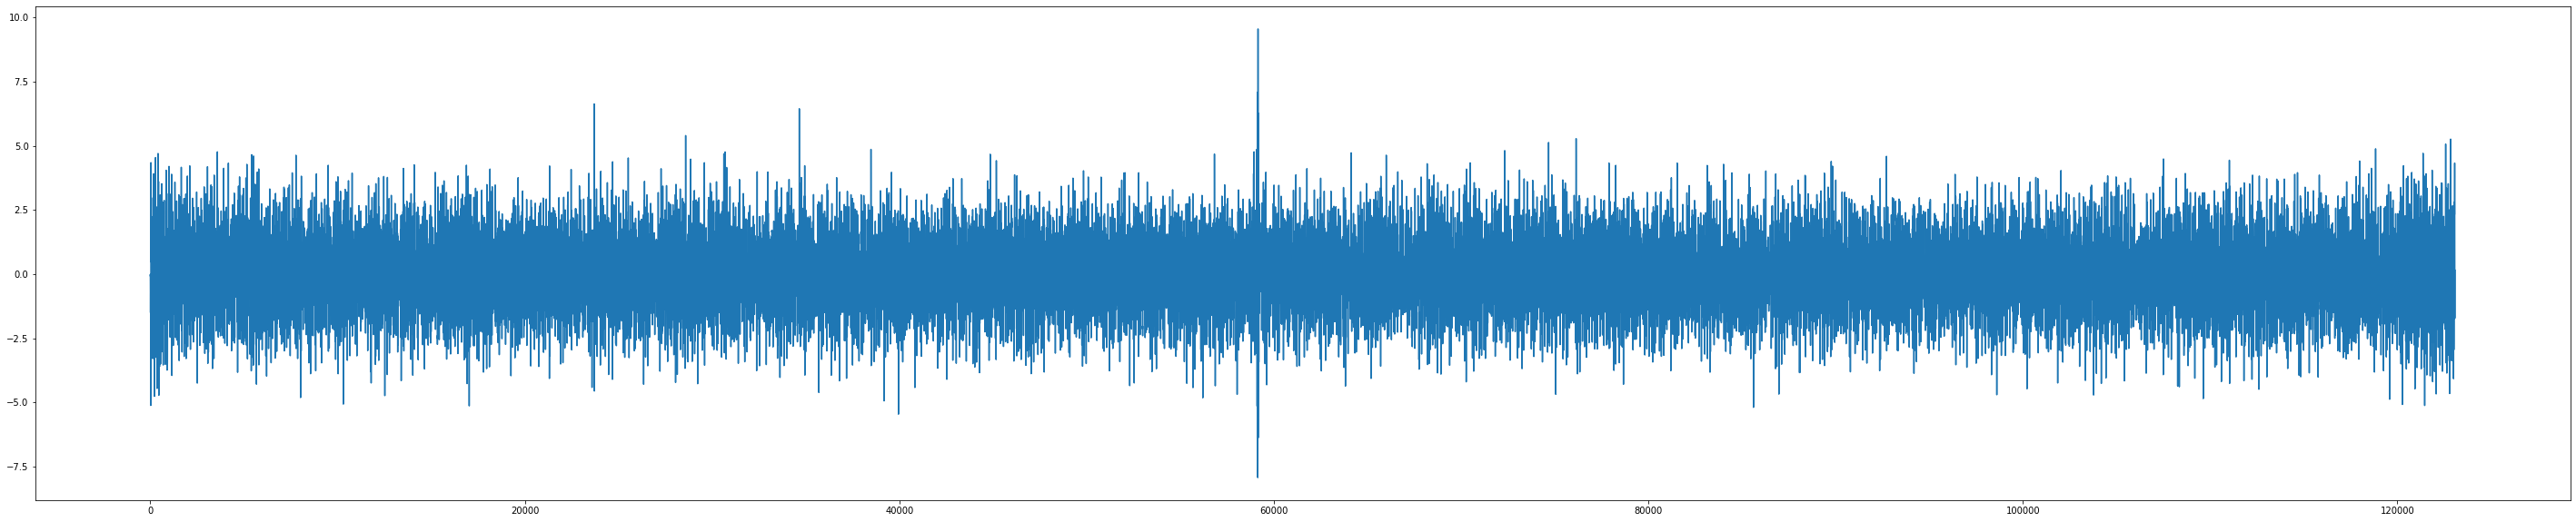

In [ ]:
w_strain_L = np.real(whiten_btuckey(strain_L1, silences[3], MM=15))
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_L1_whitenbp = filtfilt(bb, ab, np.real(w_strain_L))
plt.figure(figsize=(50,10));
plt.plot(strain_L1_whitenbp[4000:-4000])

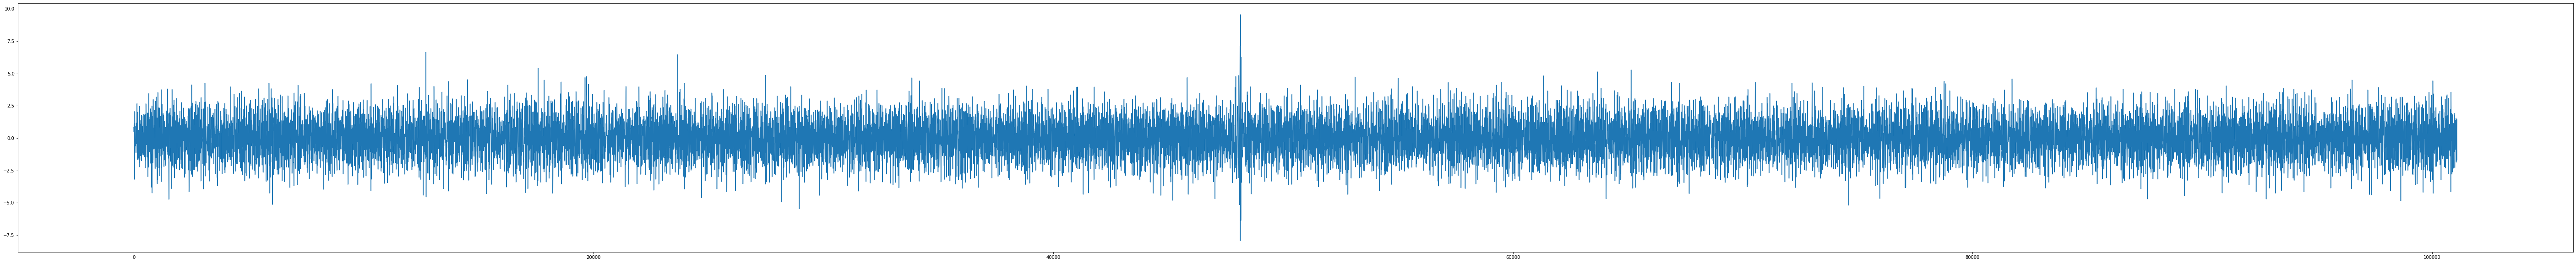

In [ ]:
plt.figure(figsize=(100,10));
plt.plot(strain_L1_whitenbp[15000:-15000])

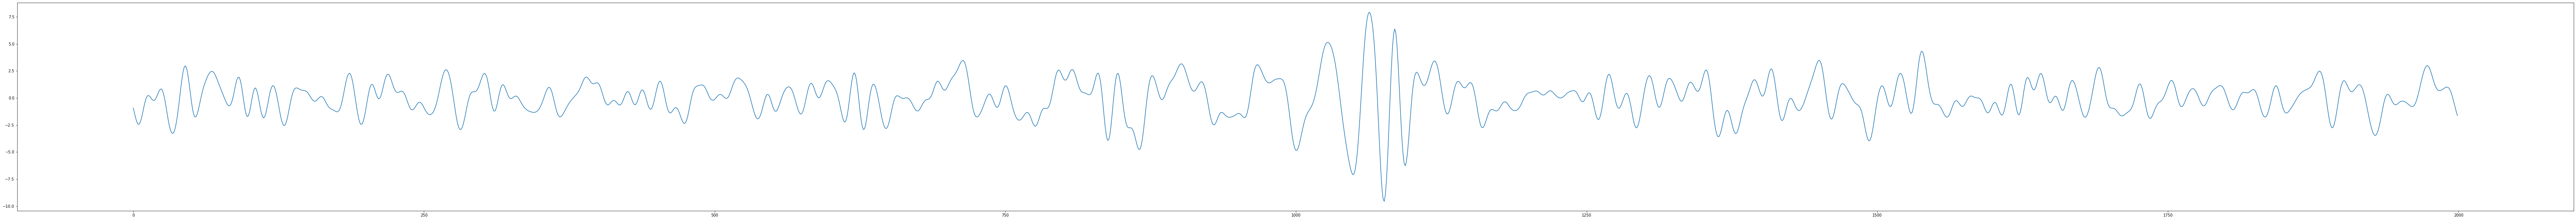

In [ ]:
plt.figure(figsize=(120,10));
index_L1 = np.where(time_L1 >= 1126259462.4)[0][0]
plt.plot(-np.real(strain_L1_whitenbp[index_L1-1000: index_L1+1000]));

¿ Se puede escuchar ?
Intentemoslo

In [ ]:
import scipy.io.wavfile

scipy.io.wavfile.write('./btuckey_bh_L1S2_hannin2.wav', 4096, strain_L1_whitenbp[4000:-4000]/np.max(strain_L1_whitenbp[4000:-4000]))
scipy.io.wavfile.write('./btuckey_bh_H1S1_hannin2.wav', 4096, strain_H1_whitenbp[4000:-4000]/np.max(strain_H1_whitenbp[4000:-4000]))

## Autocorrelación

### Ahora queremos averiguar con cuanta diferencia temporal detectaron el evento los interferometros de Hamford y de Livingston
Para averiguarlo computameros la función de correlación entre 2 versiones blanqueadas y filtradas del strain. Cada versión correspondiendo a una locación diferente


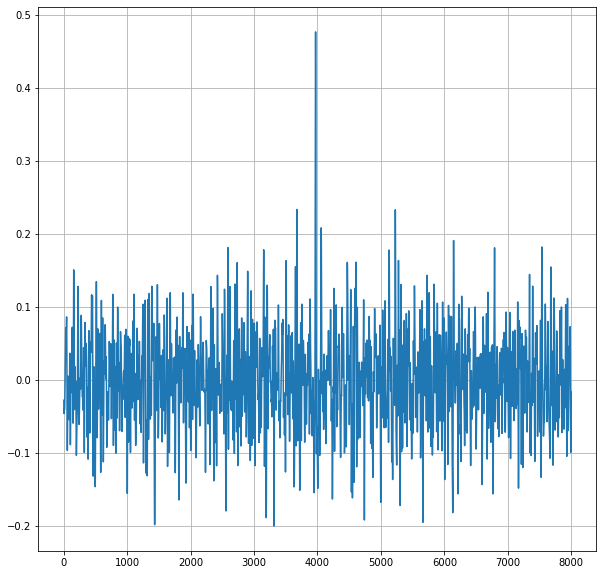

In [ ]:
largo = 4000
cross_corr_H1_L1 = signal.correlate(-np.real(strain_L1_whitenbp[index_L1-largo: index_L1 + largo]), np.real(strain_H1_whitenbp[index_L1-largo: index_L1 + largo]), mode="same", method="fft")
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(cross_corr_H1_L1 / len(cross_corr_H1_L1));

In [ ]:
lag_samples = np.abs(np.argmax(cross_corr_H1_L1)-len(cross_corr_H1_L1)//2)
time_delay = lag_samples/fs
print(f"Las ondas gravitatorias fueron detectadas con un diferencia temporal de {np.format_float_scientific(time_delay)} segundos")

Las ondas gravitatorias fueron detectadas con un diferencia temporal de 7.32421875e-03 segundos
